In [1]:
import random

import numpy as np
from matplotlib import pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Reshape, BatchNormalization, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import RMSprop, SGD
from keras.callbacks import Callback
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


# Utils

In [2]:
def plotHistory(loss):
    plt.figure(figsize=(20, 4))
    
    plt.plot(loss)
    plt.title('loss through training')
    plt.ylabel('loss')
    plt.xlabel('batch')

In [3]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [4]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

In [5]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


# Dataset

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
input_shape = (*x_train.shape[1:], 1)

In [7]:
num_classes = 10

digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
tr_pairs = np.expand_dims(tr_pairs, axis=4)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
te_pairs = np.expand_dims(te_pairs, axis=4)

# Network

In [8]:
base_network = Sequential([
    Convolution2D(4, kernel_size=3, padding="same", input_shape=input_shape),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(strides=2),
    
    Dropout(0.1),
    
    Flatten(),
    Dense(128),
])

In [9]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

output_a = base_network(input_a)
output_b = base_network(input_b)

distance = Lambda(euclidean_distance)([output_a, output_b])

model = Model([input_a, input_b], distance)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 128)           100536      input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 1)             0           sequential_1[1][0]      

# Hyper Parameters

In [10]:
rms = RMSprop()
sgd = SGD(lr=0.001, momentum=0.9, decay=1e-6)
model.compile(loss=contrastive_loss, optimizer=rms)

# Train

In [11]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

In [12]:
history = LossHistory()
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=3,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
          callbacks=[history])

Train on 108400 samples, validate on 17820 samples
Epoch 1/3
108400/108400 [==============================] - 36s - loss: 1.7103 - val_loss: 0.1037
Epoch 2/3
108400/108400 [==============================] - 37s - loss: 0.1138 - val_loss: 0.0919
Epoch 3/3
108400/108400 [==============================] - 37s - loss: 0.1041 - val_loss: 0.0863


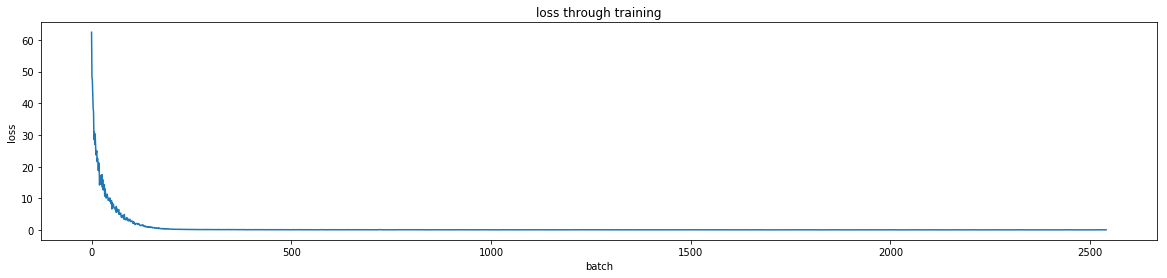

In [13]:
plotHistory(history.loss)

# Test

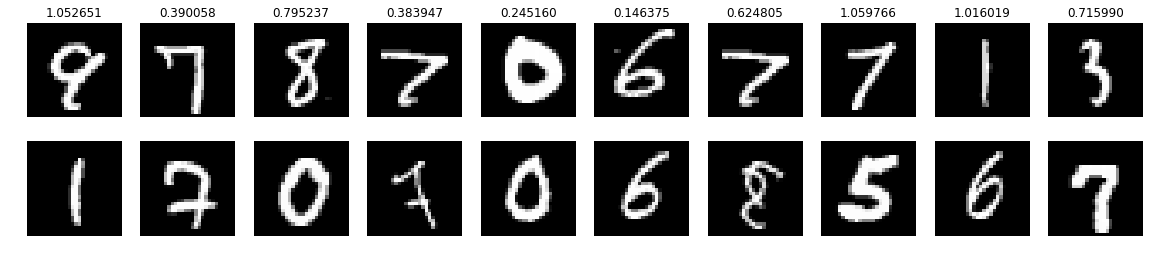

In [14]:
n_display = 10

index_pairs = np.random.randint(0, te_pairs.shape[0], n_display)
pairs = np.array([te_pairs[i] for i in index_pairs])

distances = model.predict([pairs[:, 0], pairs[:, 1]])

plt.figure(figsize=(20, 4))
for index_display, pair in enumerate(pairs):
    
    ax = plt.subplot(2, n_display, index_display + 1)
    plt.imshow(pair[0].reshape((28, 28)), cmap="gray")
    ax.set_axis_off()
    ax.set_title("{:2f}".format(distances[index_display][0]))
    
    ax = plt.subplot(2, n_display, n_display + index_display + 1)
    plt.imshow(pair[1].reshape((28, 28)), cmap="gray")
    ax.set_axis_off()